In [4]:
import torch
import torchvision
from tqdm import trange
import cv2
from torchvision import transforms
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print(device)


# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/COMPUTER_VISION/PROJECT

cpu


In [3]:
!rm best_model.pt

rm: cannot remove 'best_model.pt': No such file or directory


In [4]:
'''
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((64, 64)),
    transforms.PILToTensor() #instead of to tensor
    
])
'''
train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
    
])

train_transform_2 = transforms.Compose([
    # you can add other transformations in this list
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(64,64), scale=(.85,.95), ratio=(1, 1)),
    transforms.RandomRotation(degrees=(-5,5), expand=False, center=None, fill=0),
    transforms.PILToTensor()
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
])

In [5]:
'''
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)

true_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))

trainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(true_train_set)},  splitted validset: {len(validation_train_set)}')
'''

"\nBATCH_SIZE = 32\n\ntrainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)\n\ntrue_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))\n\ntrainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin\nvalidloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)\n\ntestset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)\ntestloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin\n\nprint(f'entire train folder: {len(trainset)}, entire test fold

In [6]:
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = test_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [7]:
trainset.dataset.transform, validset.dataset.transform

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     PILToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     PILToTensor()
 ))

In [8]:
'''
# abbiamo verificato che su un'altro dataset (MNIST) il training funzionasse
transforms = torchvision.transforms.Compose([
        # transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
'''

"\n# abbiamo verificato che su un'altro dataset (MNIST) il training funzionasse\ntransforms = torchvision.transforms.Compose([\n        # transforms.Resize((64, 64)),\n        torchvision.transforms.ToTensor(),\n        torchvision.transforms.Normalize((0.1307,), (0.3081,))\n])\n\ntrainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)\n\ntestset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)\nvalidloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)\n"

In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32*12*12, 15)
        )

    def forward(self, x):
        x = x.float()
        return self.classifier(self.conv(x))
    

class CNNBetter(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(8),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1),
                torch.nn.BatchNorm2d(16),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32*7*7, 15)
        )

    def forward(self, x):
        x = x.float()
        return self.classifier(self.conv(x))


model = CNN().to(device)

In [10]:
def initialize_weigths_and_bias(m):
  if (type(m) == torch.nn.Linear) or (type(m) == torch.nn.Conv2d):
      torch.nn.init.constant_(m.bias.data, 0) # initialize weights
      torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
  

model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=15, bias=True)
  )
)

In [11]:
# The same plotting function from the previous lab
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

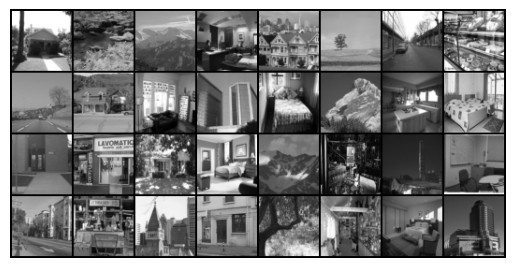

In [12]:
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

In [13]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(3.0408e-06, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0100, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))

In [14]:
# Checking initialization printing mean, std, max biases in the first convolution layer

model.conv[0].weight.mean(), model.conv[0].weight.std(), model.conv[0].bias.max()

(tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0089, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0., device='cuda:0', grad_fn=<MaxBackward1>))

In [15]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [17]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [18]:
epochs = 50
losses = []
accuracies = []
for epoch in trange(epochs, desc="Training: ", unit="epoch"):
    accuracy = get_accuracy(model, validloader)
    accuracies.append(accuracy)
    # print(f"Epoch: {epoch}, Test accuracy: {accuracy}")
    curr_loss = train_one_epoch(model, trainloader)
    losses.append(curr_loss)
print(f"Final accuracy: {get_accuracy(model, validloader)}")

Training: 100%|██████████| 50/50 [01:19<00:00,  1.59s/epoch]

Final accuracy: 0.20444445312023163


In [19]:
'''
MAX_SAME_EPOCH_ITER = 200
MAX_EPOCHS = 20
epoch = 0

accuracies = []
losses = []

SAVE_PATH = 'best_model.pt'

torch.save({
	"model_state_dict": model.state_dict(),
	"optimizer_state_dict": optimizer.state_dict()
}, SAVE_PATH)

while(MAX_SAME_EPOCH_ITER > 0 and epoch < MAX_EPOCHS):
	b_acccuracy = get_accuracy(model, validloader)
	print(f"Epoch: {epoch : 04d}, Test accuracy: {b_acccuracy : .03f}, rem. iters {MAX_SAME_EPOCH_ITER : 04d}", end='\r')
	one_epoch_loss = train_one_epoch(model, trainloader)
	a_accuracy = get_accuracy(model, validloader)
	
	if b_acccuracy >= a_accuracy:
		model = CNNBetter()
		optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
		checkpoint = torch.load(SAVE_PATH)
		model.load_state_dict(checkpoint["model_state_dict"])	
		optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
		MAX_SAME_EPOCH_ITER -= 1
	else:
		MAX_SAME_EPOCH_ITER = 200
		losses.append(one_epoch_loss)
		accuracies.append(a_accuracy)
		epoch += 1
		torch.save({
			"model_state_dict": model.state_dict(),
			"optimizer_state_dict": optimizer.state_dict()
		}, SAVE_PATH)
'''

'\nMAX_SAME_EPOCH_ITER = 200\nMAX_EPOCHS = 20\nepoch = 0\n\naccuracies = []\nlosses = []\n\nSAVE_PATH = \'best_model.pt\'\n\ntorch.save({\n\t"model_state_dict": model.state_dict(),\n\t"optimizer_state_dict": optimizer.state_dict()\n}, SAVE_PATH)\n\nwhile(MAX_SAME_EPOCH_ITER > 0 and epoch < MAX_EPOCHS):\n\tb_acccuracy = get_accuracy(model, validloader)\n\tprint(f"Epoch: {epoch : 04d}, Test accuracy: {b_acccuracy : .03f}, rem. iters {MAX_SAME_EPOCH_ITER : 04d}", end=\'\r\')\n\tone_epoch_loss = train_one_epoch(model, trainloader)\n\ta_accuracy = get_accuracy(model, validloader)\n\t\n\tif b_acccuracy >= a_accuracy:\n\t\tmodel = CNNBetter()\n\t\toptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\t\tcheckpoint = torch.load(SAVE_PATH)\n\t\tmodel.load_state_dict(checkpoint["model_state_dict"])\t\n\t\toptimizer.load_state_dict(checkpoint["optimizer_state_dict"])\n\t\tMAX_SAME_EPOCH_ITER -= 1\n\telse:\n\t\tMAX_SAME_EPOCH_ITER = 200\n\t\tlosses.append(one_epoch_loss)\n\t\taccuracies.app

In [20]:
'''
GL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1)

MAX_EPOCHS = 100
epoch = 0

alpha = 20

accuracies = []
losses = []
valid_errors = []

SAVE_PATH = 'best_model.pt'

optimal_error = np.inf
validation_error = 0


while(GL(validation_error, optimal_error) < alpha and epoch < MAX_EPOCHS):
	one_epoch_loss = train_one_epoch(model, trainloader)
	epoch += 1
	validation_error = 1 - get_accuracy(model, validloader)
	print(f"Epoch: {epoch : 04d}, Test loss: {one_epoch_loss : .05f}, GL: {GL(validation_error, optimal_error): e}, error: {validation_error: e}", end="\r")

	losses.append(one_epoch_loss)
	accuracies.append(1 - validation_error)

	if validation_error < optimal_error:
		optimal_error = validation_error
		torch.save({
			"model_state_dict": model.state_dict(),
			"optimizer_state_dict": optimizer.state_dict()
		}, SAVE_PATH)
print('\r')
print(f'GL: {GL(validation_error, optimal_error)}')
'''


'\nGL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1)\n\nMAX_EPOCHS = 100\nepoch = 0\n\nalpha = 20\n\naccuracies = []\nlosses = []\nvalid_errors = []\n\nSAVE_PATH = \'best_model.pt\'\n\noptimal_error = np.inf\nvalidation_error = 0\n\n\nwhile(GL(validation_error, optimal_error) < alpha and epoch < MAX_EPOCHS):\n\tone_epoch_loss = train_one_epoch(model, trainloader)\n\tepoch += 1\n\tvalidation_error = 1 - get_accuracy(model, validloader)\n\tprint(f"Epoch: {epoch : 04d}, Test loss: {one_epoch_loss : .05f}, GL: {GL(validation_error, optimal_error): e}, error: {validation_error: e}", end="\r")\n\n\tlosses.append(one_epoch_loss)\n\taccuracies.append(1 - validation_error)\n\n\tif validation_error < optimal_error:\n\t\toptimal_error = validation_error\n\t\ttorch.save({\n\t\t\t"model_state_dict": model.state_dict(),\n\t\t\t"optimizer_state_dict": optimizer.state_dict()\n\t\t}, SAVE_PATH)\nprint(\'\r\')\nprint(f\'GL: {GL(validation_error, optimal_error)}\')\n'

In [21]:
'''
model = CNNBetter()
checkpoint = torch.load(SAVE_PATH)
model.load_state_dict(checkpoint["model_state_dict"])

get_accuracy(model, validloader)
'''

'\nmodel = CNNBetter()\ncheckpoint = torch.load(SAVE_PATH)\nmodel.load_state_dict(checkpoint["model_state_dict"])\n\nget_accuracy(model, validloader)\n'

In [22]:
len(losses), len(accuracies)

(50, 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

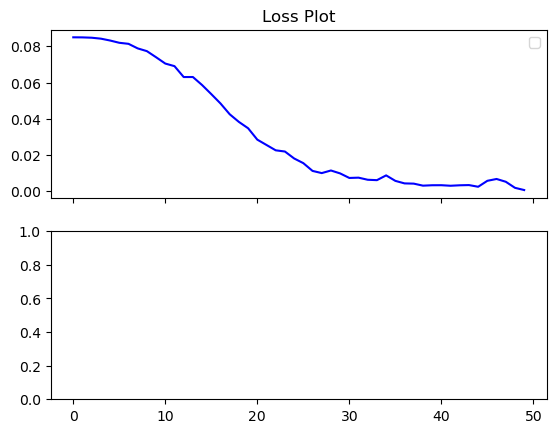

In [23]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
pred_tensor = torch.empty(len(testset), dtype = torch.uint8)
labels_tensor = torch.empty_like(pred_tensor)

for i, data in enumerate(testloader):
    x, y = data
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)

    prediction = torch.argmax(prediction, axis=1)
    
    pred_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = prediction # we have that strange equation because the dataset is not divisible by 32
    labels_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = y

In [ ]:
pred_tensor, labels_tensor

(tensor([12,  2,  4,  ...,  1,  6, 14], dtype=torch.uint8),
 tensor([ 0,  0,  0,  ..., 14, 14, 14], dtype=torch.uint8))

In [ ]:
type(trainset_classes)

list

## Ricorda di verificare perché la confusion matrix non è simmetrica anche se ad intuito dovrebbe

controllando il dataset vediamo che non bilanciato e quindi ci aspettiamo che la matrice non sia simmetrica e le classi che sono maggiormente presenti vegano classificate "più correttamente" di quelle meno presenti

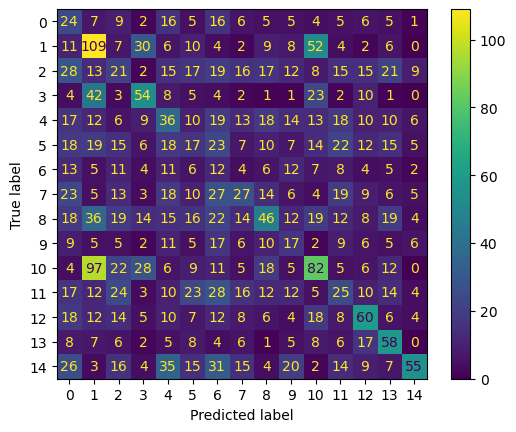

In [ ]:
pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [ ]:
trainset_classes

['Bedroom',
 'Coast',
 'Forest',
 'Highway',
 'Industrial',
 'InsideCity',
 'Kitchen',
 'LivingRoom',
 'Mountain',
 'Office',
 'OpenCountry',
 'Store',
 'Street',
 'Suburb',
 'TallBuilding']

In [ ]:
## Stampa numero immagini per classe per vedere se dataset è bilanciato
np.sum(cm, axis=1)

array([116, 260, 228, 160, 211, 208, 110, 189, 274, 115, 310, 215, 192,
       141, 256], dtype=int64)